# Water Model Calibration

In [17]:
import wntr
import pandas as pd

(<matplotlib.collections.PathCollection at 0x18802cbc5c8>,
 <matplotlib.collections.LineCollection at 0x188030f6308>)

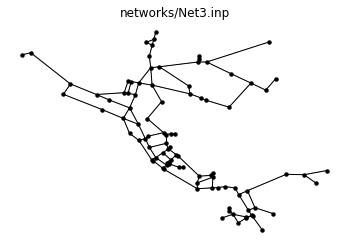

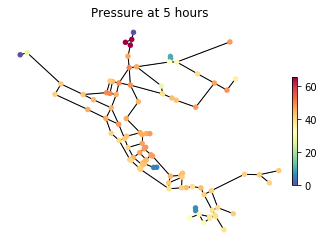

In [88]:
# Create a water network model
inp_file = 'networks/Net3.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name)

# Simulate hydraulics
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[5*3600, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=30, 
                        title='Pressure at 5 hours')

In [89]:
list(wn.pipes())[0:5]

[('20',
  <Pipe '20' from '3' to '20', length=30.1752, diameter=2.5145999999999997, roughness=199.0, minor_loss=0.0, check_valve=False, status=Open>),
 ('40',
  <Pipe '40' from '1' to '40', length=30.1752, diameter=2.5145999999999997, roughness=199.0, minor_loss=0.0, check_valve=False, status=Open>),
 ('50',
  <Pipe '50' from '2' to '50', length=30.1752, diameter=2.5145999999999997, roughness=199.0, minor_loss=0.0, check_valve=False, status=Open>),
 ('60',
  <Pipe '60' from 'River' to '60', length=375.2088, diameter=0.6095999999999999, roughness=140.0, minor_loss=0.0, check_valve=False, status=Open>),
 ('101',
  <Pipe '101' from '10' to '101', length=4328.16, diameter=0.4572, roughness=110.0, minor_loss=0.0, check_valve=False, status=Open>)]

In [90]:
for pipe in wn.pipes():
    print(pipe)

('20', <Pipe '20' from '3' to '20', length=30.1752, diameter=2.5145999999999997, roughness=199.0, minor_loss=0.0, check_valve=False, status=Open>)
('40', <Pipe '40' from '1' to '40', length=30.1752, diameter=2.5145999999999997, roughness=199.0, minor_loss=0.0, check_valve=False, status=Open>)
('50', <Pipe '50' from '2' to '50', length=30.1752, diameter=2.5145999999999997, roughness=199.0, minor_loss=0.0, check_valve=False, status=Open>)
('60', <Pipe '60' from 'River' to '60', length=375.2088, diameter=0.6095999999999999, roughness=140.0, minor_loss=0.0, check_valve=False, status=Open>)
('101', <Pipe '101' from '10' to '101', length=4328.16, diameter=0.4572, roughness=110.0, minor_loss=0.0, check_valve=False, status=Open>)
('103', <Pipe '103' from '101' to '103', length=411.48, diameter=0.4064, roughness=130.0, minor_loss=0.0, check_valve=False, status=Open>)
('105', <Pipe '105' from '101' to '105', length=774.192, diameter=0.30479999999999996, roughness=130.0, minor_loss=0.0, check_val

In [91]:
a = pipe[1]

In [92]:
a

<Pipe '333' from '601' to '61', length=0.3048, diameter=0.762, roughness=140.0, minor_loss=0.0, check_valve=False, status=Open>

In [93]:
a.todict()

{'bulk_rxn_coeff': None,
 'cv': False,
 'diameter': 0.762,
 'end_node': <Junction '61', elevation=0.0, demand_timeseries_list=<Demands: [<TimeSeries: base=0.0, pattern='1', category='None'>]>>,
 'end_node_name': '61',
 'flow': None,
 'initial_setting': None,
 'initial_status': <LinkStatus.Open: 1>,
 'length': 0.3048,
 'link_type': 'Pipe',
 'minor_loss': 0.0,
 'name': '333',
 'roughness': 140.0,
 'setting': None,
 'start_node': <Junction '601', elevation=0.0, demand_timeseries_list=<Demands: [<TimeSeries: base=0.0, pattern='1', category='None'>]>>,
 'start_node_name': '601',
 'status': <LinkStatus.Open: 1>,
 'tag': None,
 'vertices': [],
 'wall_rxn_coeff': None}

In [94]:
pipesDict = {}
pipes = [pipeTup[1] for pipeTup in wn.pipes()]
for pipe in pipes:
#     pipe.diameter = 0
    pipeDict = pipe.todict()
    for k,v in pipeDict.items():
        if k in pipesDict:
            pipesDict[k].append(v)
        else:
            pipesDict[k] = [v]
pipesDF = pd.DataFrame(pipesDict)

In [95]:
pipesDF

,bulk_rxn_coeff,cv,diameter,end_node,end_node_name,flow,initial_setting,initial_status,length,link_type,minor_loss,name,roughness,setting,start_node,start_node_name,status,tag,vertices,wall_rxn_coeff
0,None,False,2.5146,20,20,None,None,1,30.1752,Pipe,0.0,20,199.0,None,3,3,1,None,[],None
1,None,False,2.5146,40,40,None,None,1,30.1752,Pipe,0.0,40,199.0,None,1,1,1,None,[],None
2,None,False,2.5146,50,50,None,None,1,30.1752,Pipe,0.0,50,199.0,None,2,2,1,None,[],None
3,None,False,0.6096,60,60,None,None,1,375.2088,Pipe,0.0,60,140.0,None,River,River,1,None,[],None
4,None,False,0.4572,101,101,None,None,1,4328.1600,Pipe,0.0,101,110.0,None,10,10,1,None,[],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,None,False,0.3048,275,275,None,None,1,91.4400,Pipe,0.0,323,130.0,None,201,201,1,None,[],None
113,None,False,0.2032,271,271,None,None,1,393.1920,Pipe,0.0,325,130.0,None,269,269,1,None,[],None
114,None,False,0.7620,123,123,None,None,1,13868.4000,Pipe,0.0,329,140.0,None,61,61,1,None,[],None
115,None,False,0.7620,601,601,None,None,0,0.3048,Pipe,0.0,330,140.0,None,60,60,0,None,[],None


In [117]:
def extractDataFrame(wn,objType="Pipe"):
    objsDict = {}
    try:
        objIter = wn.pipes()
        if objType == "Junction":
            objIter = wn.junctions()
        for obj in objIter:
            obj = obj[1]
            objDict = obj.todict()
            for k,v in objDict.items():
                if k in objsDict.keys():
                    objsDict[k].append(v)
                else:
                    objsDict[k] = [v]
        objsDF = pd.DataFrame(objsDict)
        return objsDF
    except:
        return objsDict

In [118]:
extractDataFrame(wn)

,bulk_rxn_coeff,cv,diameter,end_node,end_node_name,flow,initial_setting,initial_status,length,link_type,minor_loss,name,roughness,setting,start_node,start_node_name,status,tag,vertices,wall_rxn_coeff
0,None,False,2.5146,20,20,None,None,1,30.1752,Pipe,0.0,20,199.0,None,3,3,1,None,[],None
1,None,False,2.5146,40,40,None,None,1,30.1752,Pipe,0.0,40,199.0,None,1,1,1,None,[],None
2,None,False,2.5146,50,50,None,None,1,30.1752,Pipe,0.0,50,199.0,None,2,2,1,None,[],None
3,None,False,0.6096,60,60,None,None,1,375.2088,Pipe,0.0,60,140.0,None,River,River,1,None,[],None
4,None,False,0.4572,101,101,None,None,1,4328.1600,Pipe,0.0,101,110.0,None,10,10,1,None,[],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,None,False,0.3048,275,275,None,None,1,91.4400,Pipe,0.0,323,130.0,None,201,201,1,None,[],None
113,None,False,0.2032,271,271,None,None,1,393.1920,Pipe,0.0,325,130.0,None,269,269,1,None,[],None
114,None,False,0.7620,123,123,None,None,1,13868.4000,Pipe,0.0,329,140.0,None,61,61,1,None,[],None
115,None,False,0.7620,601,601,None,None,0,0.3048,Pipe,0.0,330,140.0,None,60,60,0,None,[],None


In [120]:
extractDataFrame(wn,"Junction")

,base_demand,coordinates,demand,demand_timeseries_list,elevation,head,initial_quality,leak_area,leak_demand,leak_discharge_coeff,leak_status,minimum_pressure,name,node_type,nominal_pressure,tag
0,0.000000,"(9.0, 27.85)",None,"[<TimeSeries: base=0.0, pattern='1', category=...",44.80560,None,0.0,0.0,None,0.0,False,0.0,10,Junction,20.0,None
1,0.000063,"(38.68, 23.76)",None,"[<TimeSeries: base=6.30901964e-05, pattern='3'...",9.75360,None,0.0,0.0,None,0.0,False,0.0,15,Junction,20.0,None
2,0.000000,"(29.44, 26.91)",None,"[<TimeSeries: base=0.0, pattern='1', category=...",39.31920,None,0.0,0.0,None,0.0,False,0.0,20,Junction,20.0,None
3,0.000063,"(25.46, 10.52)",None,"[<TimeSeries: base=6.30901964e-05, pattern='4'...",3.81000,None,0.0,0.0,None,0.0,False,0.0,35,Junction,20.0,None
4,0.000000,"(27.02, 9.81)",None,"[<TimeSeries: base=0.0, pattern='1', category=...",40.20312,None,0.0,0.0,None,0.0,False,0.0,40,Junction,20.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0.000000,"(23.38, 12.95)",None,"[<TimeSeries: base=0.0, pattern='1', category=...",6.40080,None,0.0,0.0,None,0.0,False,0.0,267,Junction,20.0,None
88,0.000000,"(25.03, 12.14)",None,"[<TimeSeries: base=0.0, pattern='1', category=...",0.00000,None,0.0,0.0,None,0.0,False,0.0,269,Junction,20.0,None
89,0.000000,"(25.97, 11.0)",None,"[<TimeSeries: base=0.0, pattern='1', category=...",1.82880,None,0.0,0.0,None,0.0,False,0.0,271,Junction,20.0,None
90,0.000000,"(29.16, 7.38)",None,"[<TimeSeries: base=0.0, pattern='1', category=...",2.43840,None,0.0,0.0,None,0.0,False,0.0,273,Junction,20.0,None


In [96]:
>>> junction = wn.get_node('121')
>>> junction.elevation = 5
>>> pipe = wn.get_link('122')
>>> pipe.diameter = pipe.diameter*0.5
>>> tank = wn.get_node('1')
>>> tank.diameter = tank.diameter*1.1

In [97]:
pipe

<Pipe '122' from '121' to '120', length=624.84, diameter=0.1016, roughness=130.0, minor_loss=0.0, check_valve=False, status=Open>

In [98]:
wn.links()

<generator object LinkRegistry.__call__ at 0x0000018802E5C7C8>

In [99]:
def waterNetworkToDataFrame():
    dfDict = {}
    
    return 0

In [100]:
sim = wntr.sim.EpanetSimulator(wn)

In [101]:
results = sim.run_sim()

(<matplotlib.collections.PathCollection at 0x188030f32c8>,
 <matplotlib.collections.LineCollection at 0x18803244588>)

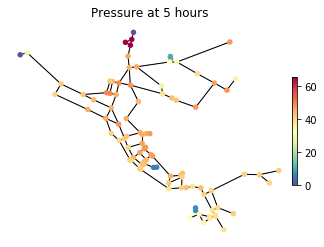

In [102]:
pressure_at_5hr = results.node['pressure'].loc[5*3600, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=30, 
                        title='Pressure at 5 hours')

In [103]:
class WNLink():
    def __init__(self,pipeToCopy):
        self.basePipe = pipeToCopy
        self.dict = pipeToCopy.todict()
        self.network = pipeToCopy.wn
    def updateNetwork(network):
        toUpdate = network.get_link(self.dict["name"])
        toUpdate.diameter = 0.5
    def __repr__(self):
        return "hello world"

In [104]:
b = WNLink(a)

AttributeError: 'Pipe' object has no attribute 'wn'

In [105]:
b.dict

{'bulk_rxn_coeff': None,
 'cv': False,
 'diameter': 0.762,
 'end_node': <Junction '61', elevation=0.0, demand_timeseries_list=<Demands: [<TimeSeries: base=0.0, pattern='1', category='None'>]>>,
 'end_node_name': '61',
 'flow': None,
 'initial_setting': None,
 'initial_status': <LinkStatus.Open: 1>,
 'length': 0.3048,
 'link_type': 'Pipe',
 'minor_loss': 0.0,
 'name': '333',
 'roughness': 140.0,
 'setting': None,
 'start_node': <Junction '601', elevation=0.0, demand_timeseries_list=<Demands: [<TimeSeries: base=0.0, pattern='1', category='None'>]>>,
 'start_node_name': '601',
 'status': <LinkStatus.Open: 1>,
 'tag': None,
 'vertices': [],
 'wall_rxn_coeff': None}

In [106]:
b

hello world